In [5]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir / 'OCT mouse' / 'Whole' / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)

# Segmentation 

In [5]:
from skimage.exposure import match_histograms
from skimage.exposure import rescale_intensity
import tifffile as tiff

def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

In [6]:
whole_seg_path = data_dir / 'OCT mouse'  / 'Whole' / 'imgs' / 'segmentation'
mask_path = data_dir / 'OCT mouse'  / 'Whole' / 'imgs' / 'masks_deepcell'

mask_path .mkdir(parents=True, exist_ok=True)

In [7]:
from deepcell.applications import Mesmer, NuclearSegmentation
from deepcell.utils.plot_utils import make_outline_overlay

app = Mesmer()

In [8]:
postprocess_kwargs_cell = {
                'maxima_threshold': 0.05,
                'interior_threshold': 0.05,
            }

postprocess_kwargs_nuclei = {
                'maxima_threshold': 0.1,
                'interior_threshold': 0.3,
            }

In [9]:
for p in tqdm(os.listdir(whole_seg_path)):
    img = skimage.io.imread(whole_seg_path / p)
    
    # Nuclei and cytosol segmentation
    img_dapi = img[..., 2]
    img_cyto = img[..., 1]
    X_train = np.stack([img_dapi, img_cyto], axis=-1)[np.newaxis,...]

    # Mask in shape (batch, x ,y, c)
    masks = app.predict(X_train, image_mpp=0.4962, compartment='both', postprocess_kwargs_whole_cell=postprocess_kwargs_cell, postprocess_kwargs_nuclear=postprocess_kwargs_nuclei)
    mask_cyto = masks[0, ..., 0]
    mask_nuclei = masks[0, ..., 1]
    
    # Save
    file_path = mask_path / p
    tiff.imwrite(file_path, mask_cyto)
    file_path = mask_path / f'Nuclei_{p}'
    tiff.imwrite(file_path, mask_nuclei)

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\thu71\AppData\Roaming\Python\Python310\site-packages\deepcell_toolbox\deep_watershed.py:108: UserWarning: h_maxima peak finding algorithm was selected, but the provided image is larger than 5k x 5k pixels.This will lead to slow prediction performance.
  warnings.warn('h_maxima peak finding algorithm was selected, '


In [54]:
img_dapi = img[..., 2]
img_cyto = img[..., 1]

In [67]:
size = 1500
x_min = 5000
x_max = x_min + size
y_min= 500
y_max = y_min + size

img_dapi_test = img_dapi[y_min:y_max, x_min:x_max]
img_cyto_test = img_cyto[y_min:y_max, x_min:x_max]

In [68]:
X_train = np.stack([img_dapi_test, img_cyto_test], axis=-1)[np.newaxis,...]
rgb_images = make_color_overlay(X_train)


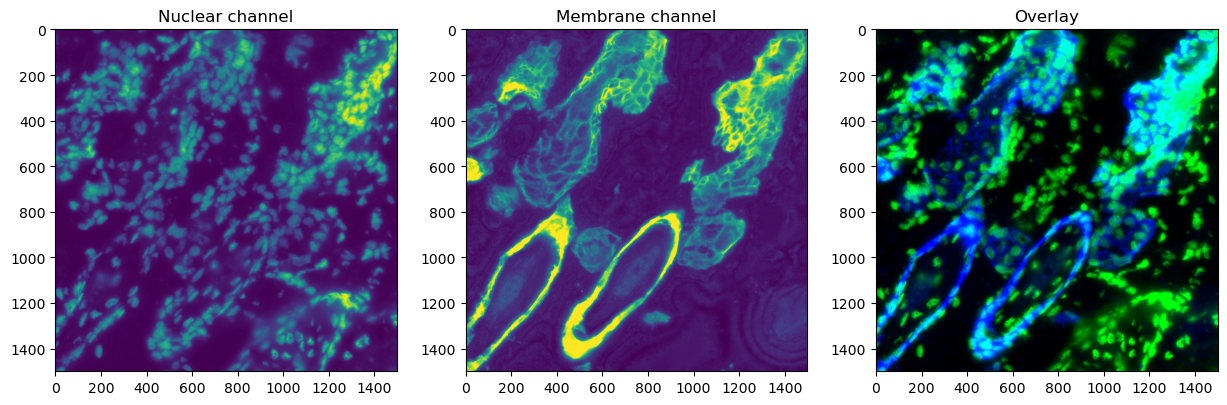

In [69]:
idx = 0 

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(X_train[idx, ..., 0])
ax[1].imshow(X_train[idx, ..., 1])
ax[2].imshow(rgb_images[idx, ...])

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()

In [70]:
from deepcell.applications import Mesmer, NuclearSegmentation
from deepcell.utils.plot_utils import make_outline_overlay

app = Mesmer()

In [71]:
postprocess_kwargs_cell = {
                'maxima_threshold': 0.05,
                'interior_threshold': 0.05,
            }

postprocess_kwargs_nuclei = {
                'maxima_threshold': 0.1,
                'interior_threshold': 0.3,
            }

In [72]:
segmentation_predictions = app.predict(X_train, image_mpp=0.1882, compartment='both', postprocess_kwargs_whole_cell=postprocess_kwargs_cell, postprocess_kwargs_nuclear=postprocess_kwargs_nuclei)

In [73]:
overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions[...,:1])
overlay_data_nuc = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions[...,1:])


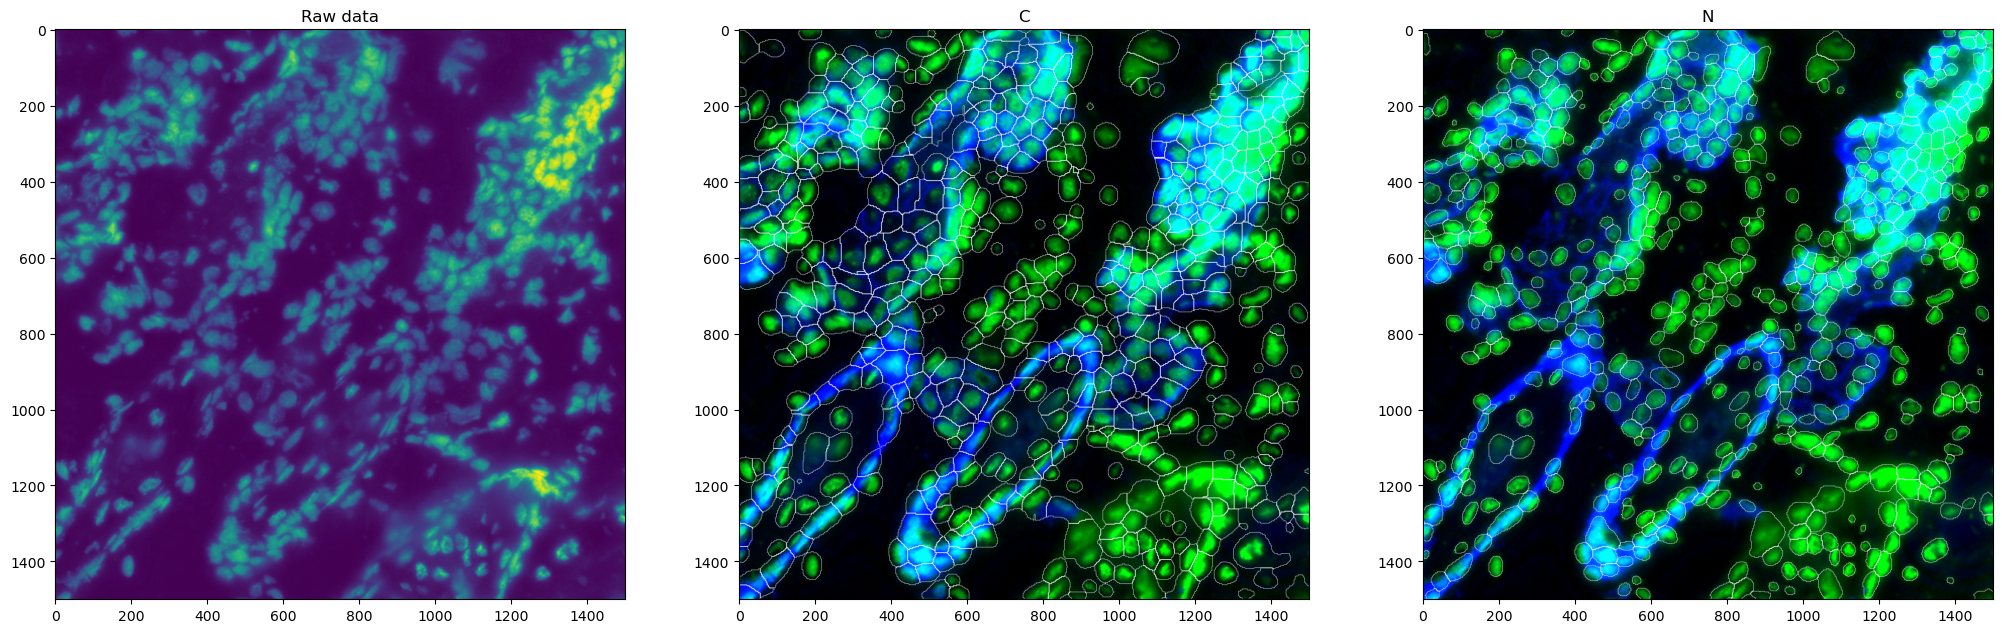

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(25, 15))
ax[0].imshow(X_train[idx, ..., 0])
ax[1].imshow(overlay_data[idx, ...])
ax[2].imshow(overlay_data_nuc[idx, ...])
ax[0].set_title('Raw data')
ax[1].set_title('C')
ax[2].set_title('N')
plt.show()

# Spot Detection

In [19]:
import PLA

PPI_save_path =  data_dir / 'OCT mouse' / 'Whole' / 'PPI'
PPI_save_path.mkdir(parents=True, exist_ok=True)

In [52]:
PPI_names = ['TEAD1 & YAP1', 'CylinE & CDK2', 'P-ERK & c-MYC', 'p-AKT & mTOR', 'Mcl-1 & BAK']

for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    pla_detect = PLA.PLA_detection(path)
    
    imgs_spots = []
    imgs_wths = []
    for PPI_pair in PPI_names: 
        img_spot, img_wth, _, _ = pla_detect.detect_spot(PPI_pair, thres=0.04)
        imgs_spots.append(img_spot)
        imgs_wths.append(img_wth)
        
    # Save PPI dict
    name = '_'.join(row[1:3])+'.pkl'
    pla_detect.save_pickle(PPI_save_path / name)
    

Reading image TEAD1 & YAP1
Processing image TEAD1 & YAP1
(array([0, 1], dtype=uint8), array([113173604,    950801], dtype=int64))
Reading image CylinE & CDK2
Processing image CylinE & CDK2
(array([0, 1], dtype=uint8), array([112352890,   1771515], dtype=int64))
Reading image P-ERK & c-MYC
Processing image P-ERK & c-MYC
(array([0, 1], dtype=uint8), array([110351767,   3772638], dtype=int64))
Reading image p-AKT & mTOR
Processing image p-AKT & mTOR
(array([0, 1], dtype=uint8), array([113781232,    343173], dtype=int64))
Reading image Mcl-1 & BAK
Processing image Mcl-1 & BAK
(array([0, 1], dtype=uint8), array([113818169,    306236], dtype=int64))
File exist. Deleted
Reading image TEAD1 & YAP1
Processing image TEAD1 & YAP1
(array([0, 1], dtype=uint8), array([83397116,   919858], dtype=int64))
Reading image CylinE & CDK2
Processing image CylinE & CDK2
(array([0, 1], dtype=uint8), array([82795052,  1521922], dtype=int64))
Reading image P-ERK & c-MYC
Processing image P-ERK & c-MYC
(array([0, 

In [53]:
# import napari

# viewer = napari.view_image(np.stack(imgs_wths))
# viewer.add_image(np.stack(imgs_spots), contrast_limits=[0,1])

# Extract cell info

In [54]:
from skimage import morphology, measure
from skimage.segmentation import clear_border
    
def count_pixel_label_mask(regionmask, intensity_image):
    v,c = np.unique(intensity_image[regionmask], return_counts=True)
    return dict(zip(v,c))
    
# Quality control of mask
def qc_nuclei(mask_cyto, mask_nuclei, small_size=100):
    '''
    Function to check if cell masks contain nuclei
    '''
    # Dictionnary storing nuclei and cyto label to cell id 
    nuclei2cell = {}
    cyto2cell = {}
    
    # Filter out small objects
    mask_cyto = morphology.remove_small_objects(mask_cyto,  min_size=small_size)
    
    # Filter out mask touching border
    mask_cyto = clear_border(mask_cyto)
    
    # Filtered only cell mask region
    cell_mask = np.where(mask_cyto > 0, 1, 0)
    mask_nuclei_filtered = mask_nuclei * cell_mask
    mask_nuclei_filtered =  morphology.remove_small_objects(mask_nuclei_filtered,  min_size=small_size)
    
    nuclei_mask = np.where(mask_nuclei>0, 1, 0)
    cyto = (mask_cyto - mask_cyto*nuclei_mask).astype(np.uint16)
    
    # Count pixel cell label in each nuclei region to assign each nuclei to cell
    props = measure.regionprops(mask_nuclei_filtered, intensity_image=mask_cyto, 
                    extra_properties=(count_pixel_label_mask,))
    nuclei_labels = []
    cell_labels = []
    for prop in props:
        df = pd.DataFrame.from_dict(prop['count_pixel_label_mask'], orient='index').reset_index()
        df.columns = ['Label', 'Count']
        corresponding_label = df.iloc[df['Count'].argmax(axis=0)]['Label']
        nuclei_labels.append(prop['Label'])
        cell_labels.append(corresponding_label)
    
    df = pd.DataFrame({'Nuclei': nuclei_labels, 'Cyto': cell_labels})
    return mask_cyto, mask_nuclei_filtered, cyto, df

In [55]:
 from collections import defaultdict

data_dir = (Path().cwd().parents[0] / 'data').absolute()

# Get image dataframe 
df_imgs_path = data_dir / 'OCT mouse'  / 'Whole' / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_imgs_path)


In [59]:
# Read masks paths 
mask_dir = data_dir / 'OCT mouse'/ 'Whole' / 'imgs' / 'masks_deepcell'
mask_filt_dir = data_dir / 'OCT mouse' / 'Whole' / 'imgs' / 'masks_filtered'
whole_seg_path = data_dir / 'OCT mouse'  / 'Whole' / 'imgs' / 'segmentation'

mask_filt_dir.mkdir(parents=True, exist_ok=True)

# Read mask paths
masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_dir / path
    else:
        masks_path[name]['cyto'] = mask_dir / path

# Read seg imgs path
for path in os.listdir(whole_seg_path):
    name = path.split('.')[0]
    masks_path[name]['seg'] = whole_seg_path / path

In [60]:
for row in df_imgs.itertuples():
    # Read image
    path = row.Path
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cyto']
    mask_nuclei_path = masks_path[name]['nuclei']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    
    # Read seg image
    img_seg = skimage.io.imread(masks_path[name]['seg'])
    
    cell, nuclei, cyto, df = qc_nuclei(mask_cyto, mask_nuclei)
    
    file_path =  mask_filt_dir / f'Nuclei_{name}.tif'
    tiff.imwrite(file_path, nuclei)
    file_path =  mask_filt_dir / f'Cell_{name}.tif'
    tiff.imwrite(file_path, cell)
    file_path =  mask_filt_dir / f'Cyto_{name}.tif'
    tiff.imwrite(file_path, cyto)
    file_path =  mask_filt_dir / f'df_{name}.csv'
    df.to_csv(file_path, index=False)

In [ ]:
# import napari

# viewer = napari.view_image(img_seg)
# viewer.add_labels(cell)
# viewer.add_labels(nuclei)

# Assign PPI to cells

In [82]:
import pickle 
from sklearn.neighbors import NearestNeighbors

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def create_PPI_df(PPI_labels, PPI_loc, name, cyto=True):
    if cyto:
        columns_name = ['Cyto', 'x', 'y']
    else:
        columns_name = ['Nuclei', 'x', 'y']
    df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_loc]), 
                      columns=columns_name)
    df['PPI'] = name
    return df

def plot_spot_on_image(reference, spots, labels, spacing=1, radius=1):
        spot_img = np.zeros_like(reference)
        coords = (spots[:, :3] / spacing).astype(int)
        r = radius  # shorthand
        for i, coord in enumerate(coords):
            slc = tuple(slice(x-r, x+r) for x in coord)
            spot_img[slc] = labels[i]
        return spot_img

def nearest_cell(x_pixel, y_pixel, 
                 x_neighborhood_min_pixel,
                 y_neighborhood_min_pixel,
                 mask_array,
                 min_dist=10):
    """Check if nearest nucleus is within user-specified distance.
       If function returns 0, it means no suitable nucleus was found."""

    # When we take a neighborhood slice of mask_array, all indices start at (0,0,0).
    # This INDEX_SHIFT is necessary to reconstruct coordinates from original mask_array.
    INDEX_SHIFT = np.array([x_neighborhood_min_pixel, 
                            y_neighborhood_min_pixel])
    cell_id = 0
    
    samples = np.stack(np.where(mask_array>0)).T
    neigh = NearestNeighbors(n_neighbors=1, radius=0.4)
    neigh.fit(samples)

    data = np.array([x_pixel, y_pixel]) - INDEX_SHIFT
    d, indice = neigh.kneighbors([data])
    d = d[0]
    indice = indice[0]
    if d < min_dist:
        cell_id = mask_array[samples[indice][0][0], samples[indice][0][1]]
    return cell_id

In [83]:
mask_filt_dir = data_dir / 'OCT mouse' / 'Whole' / 'imgs' / 'masks_filtered'
PPI_save_path =  data_dir / 'OCT mouse'/ 'Whole' / 'PPI'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [90]:
min_dist = 20

for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    dfs_PPI_cyto_ori = []
    dfs_PPI_nuclei = []
    dfs_PPI_cyto = []
    
    mask_dims = {"x_size": mask_cyto.shape[0], "y_size": mask_cyto.shape[1]}

    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)

        # Cyto
        PPI_labels = mask_cyto[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k)
        df_PPI_ori = df_PPI.copy()
        dfs_PPI_cyto_ori.append(df_PPI_ori)

        for index in tqdm(range(len(df_PPI))):
            if df_PPI.loc[index, 'Cyto'] != 0:
                continue
            x_pixel, y_pixel = df_PPI.loc[index, ['x', 'y']]

            # Define neighborhood boundary for 3D ndarray slicing. Take image boundary into
            # consideration to avoid negative index.
            y_neighborhood_min_pixel = max(0, round(y_pixel-min_dist))
            y_neighborhood_max_pixel = min(mask_dims["y_size"], round(y_pixel+min_dist+1))
            x_neighborhood_min_pixel = max(0, round(x_pixel-min_dist))
            x_neighborhood_max_pixel = min(mask_dims["x_size"], round(x_pixel+min_dist+1))
            
            # If no cell mask in pixel neighborhood skip
            mask_temp = mask_cyto[x_neighborhood_min_pixel : x_neighborhood_max_pixel, y_neighborhood_min_pixel : y_neighborhood_max_pixel]
            if mask_temp.sum() == 0:
                continue
        
            cell_id = nearest_cell(x_pixel, y_pixel,
                                   x_neighborhood_min_pixel,
                                   y_neighborhood_min_pixel,
                                   mask_temp,
                                   min_dist = min_dist
                                  )
            df_PPI.loc[index, 'Cyto'] = cell_id

        dfs_PPI_cyto.append(df_PPI)
        
        # Nuclei
        PPI_labels = mask_nuclei[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k, cyto=False)
        dfs_PPI_nuclei.append(df_PPI)
            
    # Combined DFs
    df_PPI_cyto = pd.concat(dfs_PPI_cyto)
    df_PPI_nuclei = pd.concat(dfs_PPI_nuclei)
    df_PPI_nuclei['Nuclei'] = df_PPI_nuclei['Nuclei'].apply(lambda x: nuclei2cell.get(x,x))   
    df_merged = df_PPI_cyto.merge(df_PPI_nuclei)
    df_merged['Condition'] = row[1]
    df_merged['FOV'] = row[2]
    
    # Save dataframe
    path = PPI_save_path / f'{name}.csv'
    df_merged.to_csv(path, index=False)

  0%|          | 0/63686 [00:00<?, ?it/s]

  0%|          | 0/121504 [00:00<?, ?it/s]

  0%|          | 0/253643 [00:00<?, ?it/s]

  0%|          | 0/22840 [00:00<?, ?it/s]

  0%|          | 0/23307 [00:00<?, ?it/s]

  0%|          | 0/61089 [00:00<?, ?it/s]

  0%|          | 0/104350 [00:00<?, ?it/s]

  0%|          | 0/264906 [00:00<?, ?it/s]

  0%|          | 0/15189 [00:00<?, ?it/s]

  0%|          | 0/21119 [00:00<?, ?it/s]

  0%|          | 0/40847 [00:00<?, ?it/s]

  0%|          | 0/58601 [00:00<?, ?it/s]

  0%|          | 0/88922 [00:00<?, ?it/s]

  0%|          | 0/50268 [00:00<?, ?it/s]

  0%|          | 0/23627 [00:00<?, ?it/s]

  0%|          | 0/36995 [00:00<?, ?it/s]

  0%|          | 0/71192 [00:00<?, ?it/s]

  0%|          | 0/91800 [00:00<?, ?it/s]

  0%|          | 0/34758 [00:00<?, ?it/s]

  0%|          | 0/20190 [00:00<?, ?it/s]

  0%|          | 0/48327 [00:00<?, ?it/s]

  0%|          | 0/60293 [00:00<?, ?it/s]

  0%|          | 0/27319 [00:00<?, ?it/s]

  0%|          | 0/22666 [00:00<?, ?it/s]

  0%|          | 0/19534 [00:00<?, ?it/s]

In [85]:
print(mask_cyto.shape)
print(df_PPI_ori[['x', 'y']].max(axis=0))

(7445, 15329)
x     7444
y    15328
dtype: int64


In [86]:
spots = df_PPI_ori[['x', 'y']].values
labels = df_PPI_ori['Cyto'].tolist()
img_ori = plot_spot_on_image(mask_cyto, spots, labels, radius=2)

In [87]:
spots = df_PPI[['x', 'y']].values
labels = df_PPI['Cyto'].tolist()
img_new = plot_spot_on_image(mask_cyto, spots, labels, radius=2)

In [89]:
viewer = napari.view_labels(mask_cyto)
viewer.add_labels(img_ori)
viewer.add_labels(img_new)

<Labels layer 'img_new' at 0x212743bece0>

#### Some test

In [ ]:
# Show example 

for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    dfs_PPI_cyto_ori = []
    dfs_PPI_nuclei = []
    dfs_PPI_cyto = []
    
    mask_dims = {"y_size": mask_cyto.shape[0], "x_size": mask_cyto.shape[1]}

    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)

        # Cyto
        PPI_labels = mask_cyto[PPI_loc[:,0], PPI_loc[:,1]]
        df_PPI = create_PPI_df(PPI_labels, PPI_loc, k)
        break
    
    path = PPI_save_path / f'{name}.csv'
    df_PPI_matched = pd.read_csv(path)
    


In [15]:
df_PPI

,Cyto,x,y,PPI
0,0,2917,853,TEAD1 & YAP1
1,0,5278,3226,TEAD1 & YAP1
2,4092,2859,10241,TEAD1 & YAP1
3,2070,1923,8654,TEAD1 & YAP1
4,2070,1924,8651,TEAD1 & YAP1
...,...,...,...,...
48322,0,548,7118,TEAD1 & YAP1
48323,0,220,6227,TEAD1 & YAP1
48324,0,789,8466,TEAD1 & YAP1
48325,0,619,8014,TEAD1 & YAP1


In [16]:
df_PPI_matched[df_PPI_matched.PPI == k]

,Cyto,x,y,PPI,Nuclei,Condition,FOV
0,0,2917,853,TEAD1 & YAP1,0,1W,FW3
1,0,2917,853,TEAD1 & YAP1,0,1W,FW3
2,0,2917,853,TEAD1 & YAP1,0,1W,FW3
3,0,2917,853,TEAD1 & YAP1,0,1W,FW3
4,4854,5278,3226,TEAD1 & YAP1,0,1W,FW3
...,...,...,...,...,...,...,...
51296,0,548,7118,TEAD1 & YAP1,0,1W,FW3
51297,0,220,6227,TEAD1 & YAP1,0,1W,FW3
51298,0,789,8466,TEAD1 & YAP1,0,1W,FW3
51299,0,619,8014,TEAD1 & YAP1,0,1W,FW3


# Get nuclei contours

In [9]:
from skimage import measure
import cv2 

def get_contours_mask(mask):
    contours = []
    labels = []
    for l in tqdm(np.unique(mask)):
        if l == 0:
            continue
        contours.append(measure.find_contours((mask==l).astype(np.uint8), 0.8))
        labels.append(l)
    return contours, labels

def replace_with_dict2(ar, dic):
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()
    
    ks = k[sidx]
    vs = v[sidx]
    return vs[np.searchsorted(ks,ar)]

In [10]:
mask_filt_dir = data_dir / 'OCT mouse' / 'Whole' / 'imgs' / 'masks_filtered'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [11]:
contour_save_path =  data_dir / 'OCT mouse' / 'Whole' / 'contours'
contour_save_path.mkdir(parents=True, exist_ok=True)

for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_nuclei_path = masks_path[name]['nuclei']
    df_path =  masks_path[name]['df']
    
    mask_cyto = skimage.io.imread(mask_cyto_path)
    mask_nuclei = skimage.io.imread(mask_nuclei_path)
    df_cell_info = pd.read_csv(df_path)
    nuclei2cell = dict(zip(df_cell_info.iloc[:,0], df_cell_info.iloc[:,1]))   
    replaced = replace_with_dict2(mask_nuclei, nuclei2cell)
    
    # Extract contours
    # contours_cyto, labels_cyto = get_contours_mask(mask_cyto)
    contours_nuclei, labels_nuclei = get_contours_mask(replaced)
    
    # Save data
    save_path = contour_save_path / (name+'.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump([[], [], contours_nuclei, labels_nuclei], 
                    f, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/17110 [00:00<?, ?it/s]

  0%|          | 0/14764 [00:00<?, ?it/s]

  0%|          | 0/9972 [00:00<?, ?it/s]

  0%|          | 0/8915 [00:00<?, ?it/s]

  0%|          | 0/6159 [00:00<?, ?it/s]

# Extract cell mean intensity

In [20]:
from skimage import measure 

mask_filt_dir = data_dir / 'OCT mouse' / 'Whole' / 'imgs' / 'masks_filtered'
exp_save_path =  data_dir / 'OCT mouse'/ 'Whole' / 'expresion_cell'
exp_save_path.mkdir(parents=True, exist_ok=True)

masks_path = defaultdict(dict) 
for path in os.listdir(mask_filt_dir):
    name = path.split('.')[0]
    if 'Nuclei' in name:
        masks_path[name[7:]]['nuclei'] = mask_filt_dir / path
    elif 'Cyto' in name:
        masks_path[name[5:]]['cyto'] =mask_filt_dir / path
    elif 'Cell' in name:
        masks_path[name[5:]]['cell'] =mask_filt_dir / path    
    elif 'df' in name:
        masks_path[name[3:]]['df'] =mask_filt_dir / path
    else:
        pass

In [35]:
for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
     # Read image
    path = row.Path
    with h5py.File(path, "r") as f:
        markers = f['imgs'].attrs['Marker']
    indice = np.where(np.isin(markers, ['Pan-cytokeratin']))[0]
    with h5py.File(path, "r") as f:
        img = f['imgs'][indice, ...]
    
    # Read masks
    mask_cyto_path = masks_path[name]['cell']
    mask_cyto = skimage.io.imread(mask_cyto_path)
    
    # Get mean expression
    df_exp = pd.DataFrame(measure.regionprops_table(mask_cyto, img.transpose((1,2,0)), properties=['label', 'mean_intensity', 'area']))
    df_exp.columns = ['Label', 'Pan-cytokeratin Intensity', 'Area']
    
    # Save dataframe
    path = exp_save_path / f'{name}.csv'
    df_exp.to_csv(path, index=False)


In [36]:
path

WindowsPath('Y:/coskun-lab/Thomas/15_PLA/data/OCT mouse/Whole/expresion_cell/1W_FW3.csv')

# Generate PPI network

In [12]:
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
from sklearn import preprocessing
from libpysal import weights
from itertools import count
from libpysal.cg import voronoi_frames
import scipy 
from scipy.spatial import Delaunay
import itertools
import pickle

def create_network(df, t=50):   
    y,x = df['y'].to_numpy(), df['x'].to_numpy()

    # Get coordinates
    coordinates = np.vstack([x, y]).T
    points = coordinates - np.mean(coordinates, axis=0)
    
    # Delaunay
    tri = Delaunay(points)
    G = nx.Graph()
    for path in tri.simplices:
        G.add_nodes_from(path)
        edges = list(itertools.combinations(path, 2))
        G.add_edges_from(edges)
    
    # Euclidian distance
    distance = scipy.spatial.distance_matrix(points, points)
    l = t**2/np.log(t)
    distance_norm = np.exp(-distance**2/t)

    # distance_norm = np.where(distance>t, 0, np.exp(-distance*2/l))
    
    g_dist = nx.from_numpy_array(distance_norm)
    g = g_dist.edge_subgraph(G.edges()).copy() # Only keep delaunay edges
    nx.set_node_attributes(g, dict(zip(g.nodes(), df.Labels)), "labels")
    nuclei = (df.Nuclei > 0).astype(int).tolist()
    nx.set_node_attributes(g, dict(zip(g.nodes(), nuclei)), "nuclei")
    nx.set_node_attributes(g, dict(zip(g.nodes(), coordinates)), "pos")
    return g

In [13]:
PPI_save_path =  data_dir / 'OCT mouse' / 'Whole' / 'PPI'

# Read PPi info 
dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)
df = pd.concat(dfs)

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()

In [20]:
graph_save_path =  data_dir / 'OCT mouse' / 'Whole' / 'graphs' / 'raw'
graph_save_path.mkdir(parents=True, exist_ok=True)

group = df.groupby(['Condition', 'FOV', 'Cyto'])
for name, df_group in tqdm(group, total=len(group)):
    if name[2] == 0:
        continue
    
    # Remove duplicated 
    df_group.drop_duplicates(subset=['x', 'y', 'PPI'],
                             keep='first', inplace=True)
    
    if len(df_group) < 5:
        continue
        
    # Add small variatio to close PPI 
    while df_group.duplicated(subset=['x', 'y']).any():
        df_group.loc[df_group.duplicated(subset=['x', 'y']), ['x', 'y']] += [1,1] 
    
    try:
        # Generate graph and info
        g = create_network(df_group)
        if nx.number_of_isolates(g)>0:
            print('Isolated nodes')

        # Save pgrahs
        save_path = graph_save_path / ('_'.join([str(n) for n in name])+'.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(g, f, protocol=pickle.HIGHEST_PROTOCOL)
    except:continue
    

  0%|          | 0/61315 [00:00<?, ?it/s]

In [21]:
y,x = df_group['y'].to_numpy(), df_group['x'].to_numpy()

points = np.vstack([x, y]).T
tri = Delaunay(points)

G = nx.Graph()
for path in tri.simplices:
    G.add_nodes_from(path)
    edges = list(itertools.combinations(path, 2))
    G.add_edges_from(edges)
    
pos = points
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot()

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, color='b')
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color='g', lw=0.5)

QhullError: QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull d Qz Qbb Q12 Qc Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2112998807  delaunay  Qz-infinity-point  Qbbound-last  Q12-allow-wide
  Qcoplanar-keep  Qtriangulate  _pre-merge  _zero-centrum  Qinterior-keep
  _maxoutside  0
